# Strategy Testing

## Strategy Description

### What is Granger?

### Iteration 1
- Using rolling single pair granger causality tests to determine which tokens are causal at any one point in time
- At that point, fit a multivaraite rolling granger causality to predict the next data point
- Trade with size determined by goodness of fit and predicted change 

- Vary across different time frames
- Keep window size fixed (1hr for minute data, 24 hr for hour data, 30 days for daily data)
#
___

In [36]:
# imports
import os
import sys
import logging
import warnings
import logging
from itertools import combinations

# add the parent directory to the path
sys.path.append(os.path.dirname(os.path.abspath('')))
from src.data.data_processor import DataProcessor
from src.visualization.causality_viz import CausalityVisualizer
from src.analysis.causality import CausalityAnalyzer
from src.analysis.granger_causality import AutomatedGrangerAnalyzer
from src.analysis.stationarity import StationarityTester
from src.analysis.outliers import OutlierAnalyzer
from src.analysis.time_varying_granger import run_tvgc_analysis
from src.utils.helpers import calculate_returns
from src.utils.load_data import load_parquet_data

from scipy import stats
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR


### 1. Load Data

In [6]:
data_dir = "../data/processed"
interval = "1m"

returns, prices = load_parquet_data(data_dir=data_dir, interval=interval)

2025-01-02 15:49:17 - INFO - Initializing analyzer with data directory: ../data/processed
2025-01-02 15:49:17 - INFO - Starting data loading process...
2025-01-02 15:49:17 - INFO - Looking for parquet files in: c:\Users\owooding\Documents\GraduateScheme\Projects\CryptoCausality\data\processed
2025-01-02 15:49:17 - INFO - Found 6 parquet files
2025-01-02 15:49:17 - INFO - Processing file for ADAUSDT
2025-01-02 15:49:17 - INFO - Loaded 14401 rows for ADAUSDT
2025-01-02 15:49:17 - INFO - Calculating simple returns for ADAUSDT
2025-01-02 15:49:17 - INFO - Calculating price difference for ADAUSDT
2025-01-02 15:49:17 - INFO - Calculating log returns for ADAUSDT
2025-01-02 15:49:17 - INFO - Successfully processed ADAUSDT
2025-01-02 15:49:17 - INFO - Processing file for BNBUSDT
2025-01-02 15:49:17 - INFO - Loaded 14401 rows for BNBUSDT
2025-01-02 15:49:17 - INFO - Calculating simple returns for BNBUSDT
2025-01-02 15:49:17 - INFO - Calculating price difference for BNBUSDT
2025-01-02 15:49:17 - 

In [13]:
def plot_time_series_data(data, column="close", title=None, symbol=None):
    if symbol != None: 
        fig = px.line(data[f'{symbol}USDT'], x="timestamp", y=column, title=f"{symbol} Close Price", height=500)  
        fig.show()
    else: 
        for symbol in data.keys():
            fig = px.line(data[symbol], x="timestamp", y=column, title=f"{symbol} Close Price", height=300)  
            fig.show()
    

plot_time_series_data(prices, column="close", title="Close Price")

### 2. Load Causal test data

**How results are used and interpreted**

- Time varying granger causality results for each pair in a single granger rolling model.
- Gives the f-stat and p-value for each timestep which indicates the effectiveness of a multivariate OLS vs an autoregressive model over the window specified. 
- At each timestep, we should see which tokens are significant (p-value<0.5) and use them in a new multivariate VAR model to predict the next value of the target variable. 


In [16]:
# ANALYSIS VARS
TOKEN = "BTCUSDT"
INTERVAL = "1m"
RESULTS_DIR = "../results"

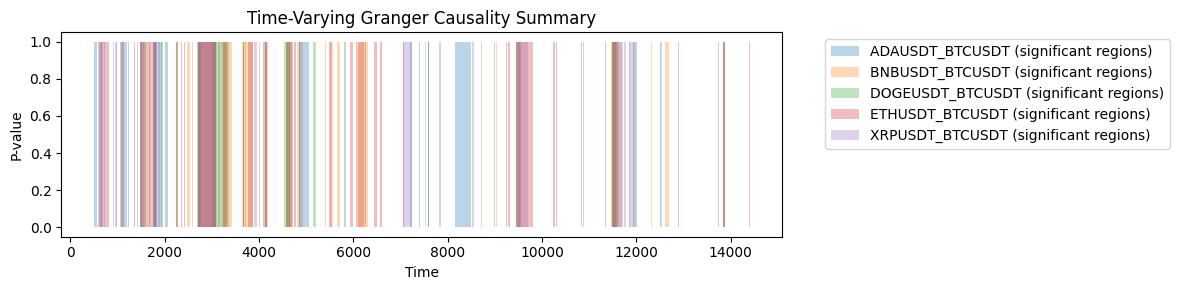

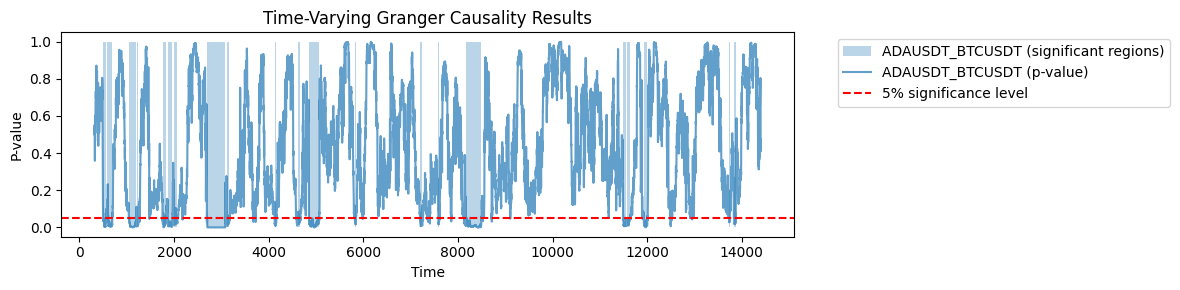

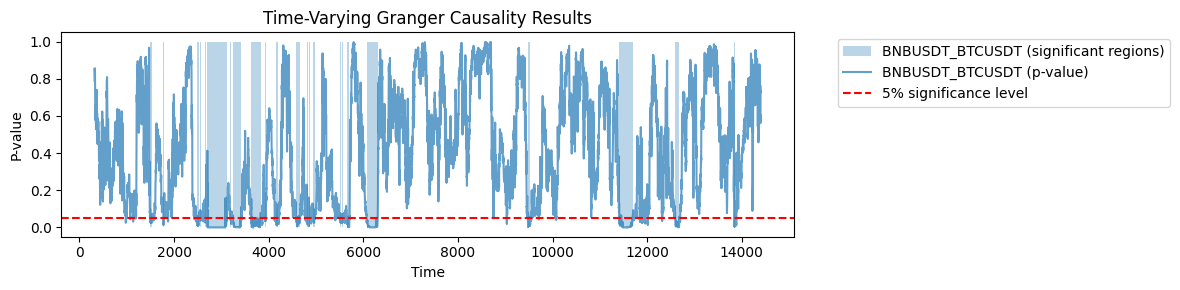

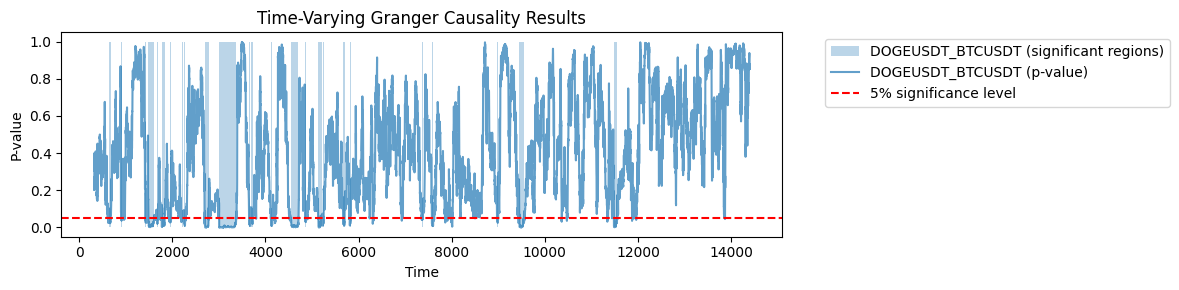

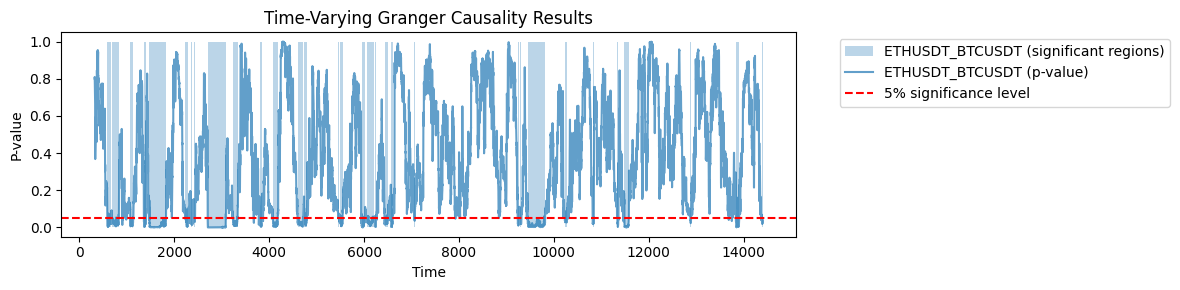

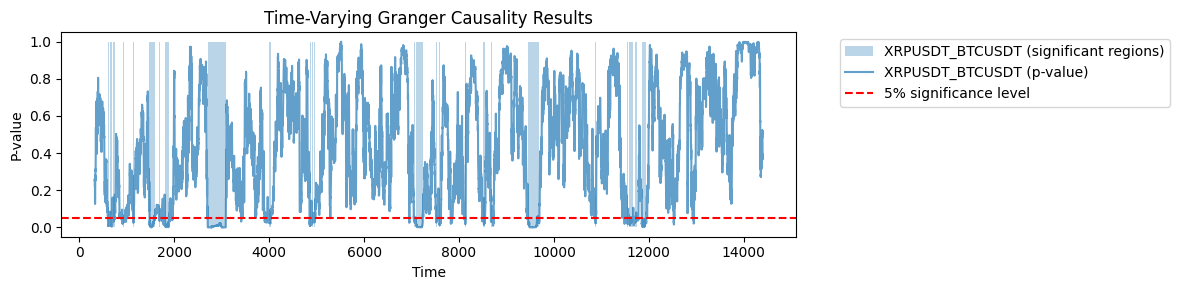

In [46]:
# GET RESULTS
def get_all_results(
    results_dir, token, interval="1m", type="time varying granger causality"
):
    results_dir = results_dir + f"/{interval}/"
    # get names of all files in the directory
    results = {}

    for file in os.listdir(results_dir):
        target_token = file.split("_")[1]
        # get all files with mathing target token and experiment type
        if (target_token == token) and (" ".join(file.split("_")[2:-1]) == type):
            results["_".join(file.split("_")[:2])] = pd.read_csv(results_dir + file)
    
    p_values_df = pd.DataFrame(index=prices[TOKEN].index)
    for symbol in results.keys():
        p_values_df[symbol] = results[symbol].set_index("date")["p_value"]

    return results, p_values_df


# PLOT RESULTS
def plot_causality_results(
    tvgc_results, figsize=(12, 3), title="Time-Varying Granger Causality Results"
):  
    if figsize is None:
            fig_combined, ax_combined = plt.subplots(figsize=(10, 10))
    else:
        fig_combined, ax_combined = plt.subplots(figsize=figsize)
    
    for pair, results in tvgc_results.items():
        if figsize is None:
            fig, ax = plt.subplots(figsize=(10, 10))
        else:
            fig, ax = plt.subplots(figsize=figsize)

        # Plot significance regions
        ax.fill_between(
            results["date"],
            0,
            1,
            where=results["significant"],
            alpha=0.3,
            label=f"{pair} (significant regions)",
        )

        # Plot significance regions on combined plot
        ax_combined.fill_between(
            results["date"],
            0,
            1,
            where=results["significant"],
            alpha=0.3,
            label=f"{pair} (significant regions)",
        )

        # Plot p-values
        ax.plot(
            results["date"], results["p_value"], label=f"{pair} (p-value)", alpha=0.7
        )

        # format individual plots
        ax.axhline(y=0.05, color="r", linestyle="--", label="5% significance level")
        ax.set_title(title)
        ax.set_xlabel("Time")
        ax.set_ylabel("P-value")
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        fig.tight_layout()
        fig.show()
    # format combined plot
    ax_combined.set_title("Time-Varying Granger Causality Summary")
    ax_combined.set_xlabel("Time")
    ax_combined.set_ylabel("P-value")
    ax_combined.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    fig_combined.tight_layout()
    fig_combined.show()

results, p_values_df = get_all_results(RESULTS_DIR, TOKEN, interval=INTERVAL)
plot_causality_results(results, title="Time-Varying Granger Causality Results")

In [ ]:
# FIND GRANGER CAUSALITY

# Set up logging with more detailed format
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

def rolling_multivariate_causality(
    returns_data,
    causal_results,
    target: str,
    window_size: int,
    max_lags: int,
    sig_level: float = 0.05,
) -> pd.DataFrame:
    """
    Run rolling multivariate Granger causality analysis using VAR model.

    Args:
        returns_data: DataFrame of all cryptocurrency returns
        causal_results: Dataframe of Granger causality results for each timestep and pair including target
        target: Target cryptocurrency to test causality for
        window_size: Size of rolling window
        max_lag: Maximum lag order for VAR model (default: None, uses AIC)
        sig_level: Significance level for p-values (default: 0.05)

    Returns:
        Tuple containing:
        - Dictionary of test statistics for each variable
        - Dictionary of coefficient p-values for each variable
        - Optimal lag order
    """
    logger.info(f"Running multivariate causality analysis for target: {target}")

    # Prepare data
    data = returns_data["log_returns"]
    data = data.dropna()

    stat_results = []
    predictions = []
    # Rolling window analysis
    for start in range(0, len(data) - window_size + 1):
        logger.info(
            f"Running multivariate causality analysis for timestep {start}/{len(data) - window_size + 1}..."
        )

        date = data.index[start + window_size - 1]
        window_data = data.iloc[start : start + window_size]

        # causal results for this window
        significant_tokens = [
            col for col, val in causal_results.loc[date].items() if val < sig_level
        ]

        # Extract coefficients and p-values for each variable
        # coef_pvals = {}
        f_stats = {col: [] for col in data.columns}
        f_stats['date'] = date
        p_values = {col: [] for col in data.columns}
        p_values['date'] = date

        # if there are significant tokens run VAR model
        if len(significant_tokens) != 0:
            logger.info(f"Significant tokens found for date: {date} - running VAR model...")
            window_data = window_data[target, significant_tokens]

            # Determine optimal lag order if not specified
            model = VAR(window_data)
            opt_lag = model.select_order(maxlags=max_lags).aic
            logger.info(f"Optimal lag order determined by AIC: {opt_lag}")

            # Fit VAR model
            model = VAR(window_data)
            results = model.fit(maxlags=opt_lag)

            # Predict next timestep
            prediction = results.forecast(window_data.values[-opt_lag:], 1)
            print(prediction)
            predictions.append(
                {
                    'date': date,
                    'pred': prediction
                }
            )

            # get test statistics and p-values for target variable
            f_stat = results.test_causality(target, significant_tokens, kind="f").test_statistic
            p_value = results.test_causality(target, significant_tokens, kind="f").pvalue
            
            logger.info(results.params)
            logger.info(f"VAR model fitted with max lag: {opt_lag}")

            # Get test statistics and p-values for target variable
            target_idx = list(window_data.columns).index(target)

            stat_results.append(
                {
                    "date": data.index[start + window_size - 1],
                    "f_stat": f_stat,
                    "p_value": p_value,
                    "significant": p_value < 0.05,
                }
            )
        else:
            logger.info(f"No significant tokens found for date: {date} - skipping VAR model...")

    return pd.DataFrame(predictions), pd.DataFrame(stat_results)



ADAUSDT_BTCUSDT  BNBUSDT_BTCUSDT  DOGEUSDT_BTCUSDT  ETHUSDT_BTCUSDT  \
0                  NaN              NaN               NaN              NaN   
1                  NaN              NaN               NaN              NaN   
2                  NaN              NaN               NaN              NaN   
3                  NaN              NaN               NaN              NaN   
4                  NaN              NaN               NaN              NaN   
...                ...              ...               ...              ...   
14396         0.480803         0.642747          0.866202         0.029007   
14397         0.409352         0.594549          0.851391         0.029021   
14398         0.450795         0.562360          0.879923         0.032418   
14399         0.474636         0.602105          0.854777         0.039066   
14400              NaN              NaN               NaN              NaN   

       XRPUSDT_BTCUSDT  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
14396         0.372880  
14397         0.365137  
14398         0.394937  
14399         0.391789  
14400              NaN  

[14401 rows x 5 columns]

In [39]:
p_values_df = pd.DataFrame(index=prices[TOKEN].index)
for symbol in results.keys():
    p_values_df[symbol] = results[symbol].set_index("date")["p_value"]

p_values_df

ADAUSDT_BTCUSDT  BNBUSDT_BTCUSDT  DOGEUSDT_BTCUSDT  ETHUSDT_BTCUSDT  \
0                  NaN              NaN               NaN              NaN   
1                  NaN              NaN               NaN              NaN   
2                  NaN              NaN               NaN              NaN   
3                  NaN              NaN               NaN              NaN   
4                  NaN              NaN               NaN              NaN   
...                ...              ...               ...              ...   
14396         0.480803         0.642747          0.866202         0.029007   
14397         0.409352         0.594549          0.851391         0.029021   
14398         0.450795         0.562360          0.879923         0.032418   
14399         0.474636         0.602105          0.854777         0.039066   
14400              NaN              NaN               NaN              NaN   

       XRPUSDT_BTCUSDT  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
14396         0.372880  
14397         0.365137  
14398         0.394937  
14399         0.391789  
14400              NaN  

[14401 rows x 5 columns]

In [45]:
[col for col, val in p_values_df.loc[14399].items() if val < 0.05]

['ETHUSDT_BTCUSDT']